# Text Clustering

$by: Jeremiah\space Chinyelugo$

In this notebook, we will performing an unsupervised learning task using algorithms like `Principal Component Analysis (P.C.A)`, `t-distributed stochastic neighbor embedding (TSNE)` and `KMeans`.

We will create 2 Kmeans model's (using a pretrained encoder and adapting a keras TextVectorization layer) and compare their performance. In the same vein, we will show why using a pretrained model or embedding is advisable in ML projects.

#### What is Clustering?
Clustering is an important unsupervised machine learning technique used for the discovery of inherent structures, patterns, and relationships in data.

It is widely used on unstructured data for:
- Data Exploaration: to understand underlying structure and distribution of data

- Data Preprocessing: to reduce dimensionality, handle missing data, outlier detection `(DBSCAN)`, and preliminary label generation

- Anomaly and Novelty Detection: to determine unusual data that differs significantly from clusters. common application is fraud detection

- Customer Segmentation: for segmenting customers based on common behaviour

#### Data

The [dataset](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive) used for this project was gotten from kaggle. 

The dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. 

#### Importing the packages

In [1]:
from absl import logging
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

# reduce logging verbosity
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['OMP_NUM_THREADS'] = '9'

In [2]:
# loading the data

data = pd.read_csv('data.csv', sep='\t')
data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


Our dataset contains labels in the column `category`, and this is why i decided to use this dataset for this project as it will allow us compare our clustering results to the actual labels.

In [3]:
# checking for null values

data.isna().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [4]:
# how many instances of each category do we have?

data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

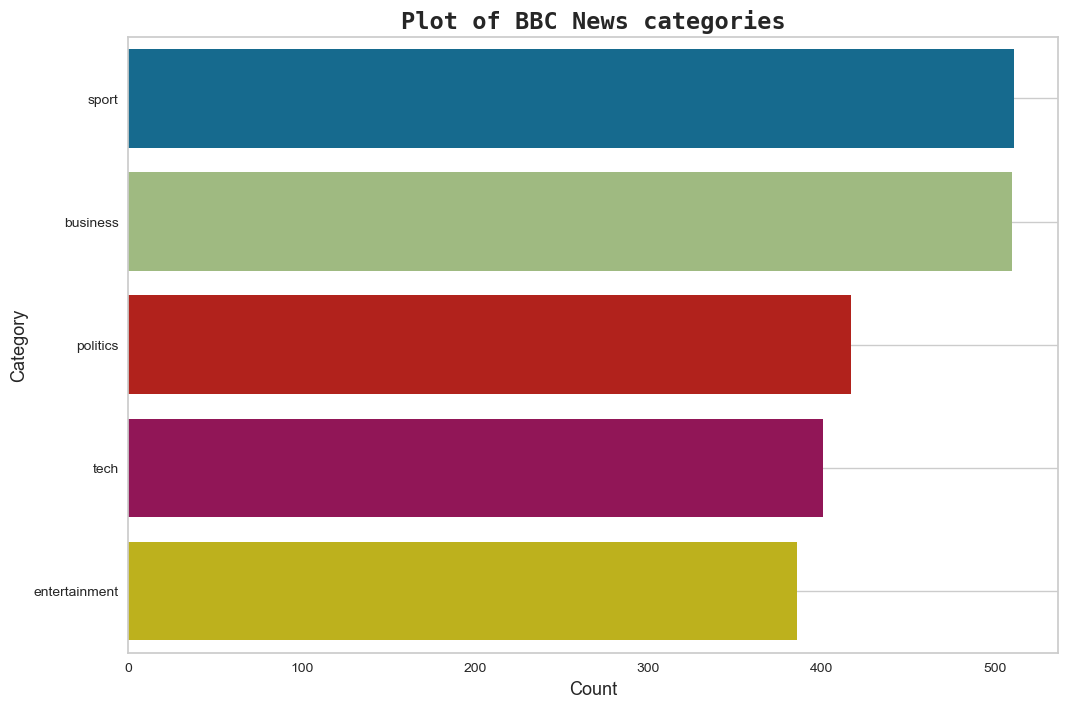

In [5]:
plt.figure(figsize=(12,8))
sns.countplot(data=data, y='category', order=['sport', 'business', 'politics', 'tech', 'entertainment'])
plt.xlabel("Count", fontsize=13)
plt.ylabel("Category", fontsize=13)
plt.title("Plot of BBC News categories", fontsize=17, weight='bold', fontname='monospace')
plt.grid(None)
plt.show()

#### Separating our clustering data

We are going to cluster the content in our dataset so we will create a new dataset from our main dataset

In [6]:
df = data[['content']]
df.head()

,content
0,Quarterly profits at US media giant TimeWarne...
1,The dollar has hit its highest level against ...
2,The owners of embattled Russian oil giant Yuk...
3,British Airways has blamed high fuel prices f...
4,Shares in UK drinks and food firm Allied Dome...


In [7]:
# showing the first instance in our dataset

print(df['content'][0])

 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-spe

Fortunately, the datset is clean, having gone through it outside this notebook. However, not all datasets we will encounter will be this clean, therefore we will have to perform data cleaning in those cases. The `Regex` library is handy for cleaning dirty data.

Also, the Keras TextVectorization layer performs some basic data cleaning.

## Part 1: Using a Keras Text Vectorization layer

In this section, we will first use a keras text vectorization layer to convert our integer indices, then reduce its dimensionality using PCA before clustering with KMeans. 

In [8]:
# creating the text vectorization layer

encoder = keras.layers.TextVectorization(
    max_tokens=50_000, output_mode='int',
)

In [9]:
# converting our clustering dataframe to a list

df_list = df['content'].tolist()

In [10]:
# adapting our list

encoder.adapt(df_list)

In [11]:
# encoder vocabulary

encoder_vocab = np.array(encoder.get_vocabulary())
encoder_vocab.size

34387

In [12]:
# getting the mapped integer indices from our text

df_vectors = encoder(df_list)
df_vectors.shape

TensorShape([2225, 4412])

our `df_vectors` is a tensor object, so we need to convert it to numpy

In [13]:
# converting tensor object to numpy array

df_vectors = df_vectors.numpy()
df_vectors

array([[3968,  689,   21, ...,    0,    0,    0],
       [   2,  476,   19, ...,    0,    0,    0],
       [   2, 1866,    4, ...,    0,    0,    0],
       ...,
       [   6,   47,  171, ...,    0,    0,    0],
       [   2,  470,  304, ...,    0,    0,    0],
       [ 259,  361,  333, ...,    0,    0,    0]], dtype=int64)

We can see from our array above that we have large numbers and 0's. 

Machine learning models (except RandomForest which are robust to outliers) do not perform well on data with varying scale, so we need to scale our data.

There are 2 main options for scaling `Normalization` & `Standardization`, we will use `Normalization` because our data is our integer indices is within a defined range based on our encoder vocabulary. If we were dealing with numbers that could vary (price of houses, distance), then a `Standardization` would have been a better option.

In [14]:
# performing Normalization

norm = Normalizer()

norm_data = norm.fit_transform(df_vectors)
norm_data

array([[3.00652339e-02, 5.22050055e-03, 1.59115401e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.10707594e-05, 5.01484075e-03, 2.00172215e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.56207006e-05, 2.39041137e-02, 5.12414013e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.05342269e-05, 3.17518111e-04, 1.15522547e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07641345e-05, 4.87957160e-03, 3.15614844e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.82431080e-04, 1.22995220e-03, 1.13455425e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [15]:
norm_data.shape

(2225, 4412)

Our normalized data has 4,412 columns which is mostly sparse, so to make it easier for our Kmeans model to find a solution, and improve its computational time, we will reduce the dimensionality of the data

In [16]:
# reducing dimensionality

pca = PCA(n_components=0.95) # we only want principal components that capture 95% of our data
df_scaled = pca.fit_transform(norm_data)

In [17]:
df_scaled.shape

(2225, 425)

We have been able to reduce our data from 4,412 features to 225

#### Clustering

We will use the YellowBrick package for to both cluster and visualize our distortion score to give us a rough idea of what clusters to select

In [18]:
# creating a helper function

def cluster_data(data, k_min=3, k_max=10):
    kmeans = KMeans(n_init=100)
    
    visualizer = KElbowVisualizer(kmeans, k=(k_min,k_max))
    visualizer.fit(df_scaled)
    visualizer.show()
    plt.show()

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

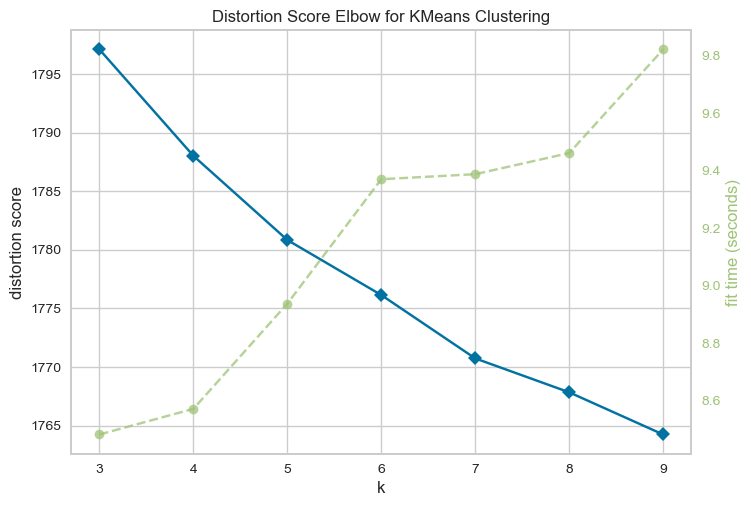

In [19]:
# clustering and visualizing the data

cluster_data(df_scaled, k_min=3, k_max= 10)

from our clustering we can see that the the distortion score drops rapidly, but a lower distortion(inertia) score does not equate a great model.

If we decide to use 100 clusters, we will have a far lower score, but does it mean the model is better? or interpretable at that level?

To fully understand how well out clustering model has performed we will use another metric. The `Silhouette` score. However before we measure our model performance using this metric, we need to choose a define k cluster.

We already know from our data that we have 5 categories, and our plot above show that 5 cluster is decent, based on the distortion score and computation time (right side of chart), so we will proceed with k=5.

In [20]:
# creating a helper function

def plot_silhouette_score(data, k=5):
    model = KMeans(k, n_init=100)

    fig = plt.figure(figsize=(15,8))

    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(data)

    fig.text(0.12,.96, "Silhouette  score (5 clusters)", fontweight='bold', 
            fontfamily='calibri', fontsize=25)
    plt.xlabel('Silhouette Coefficient Values', fontfamily='calibri', fontsize=17,)
    plt.ylabel('Cluster Label', fontfamily='calibri', fontsize=17,)

    visualizer.show()
    plt.show()

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


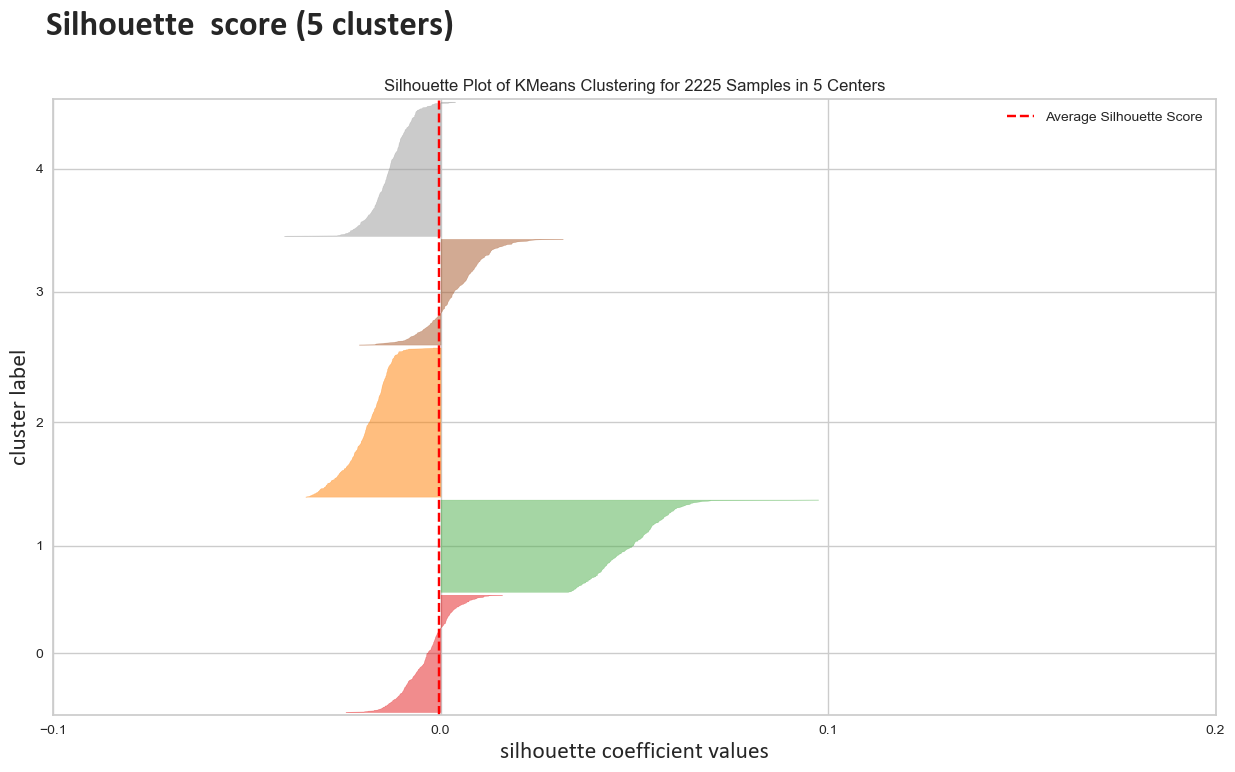

In [21]:
plot_silhouette_score(df_scaled, k=5)

From the plot of Silhouette score, we can see that our model performed poorly, even though our distortion was low. 

Even if we decided to use `TfidVectorizer` instead of a Tex vectorization layer, we would still get the same Silhouette plot (i experimented with it).

So the take away here is that, when clustering, we should not rely on the distortion(inertia) score. 

In the next section of this notebook, we will see how using a pre-trained embedding dramatically improves our model performance, make hopefully make a case for why pre-trained embeddings should be use when carrying out NLP tasks.

However, before we move to the nexct section, we will visualize our cluster labels using TSNE

In [22]:
# using TSNE to transform our dataset

tsne = TSNE()
tsne_data = tsne.fit_transform(df_scaled)

In [23]:
tsne_data

array([[-15.744428 ,  13.715631 ],
       [ 18.9283   , -12.189781 ],
       [ 32.738438 ,   3.6559942],
       ...,
       [ -9.647151 , -15.5886345],
       [-27.255964 ,   3.1492686],
       [ -9.99936  , -11.774441 ]], dtype=float32)

In [24]:
# to show our class labels we need to fit our kmeans

kmeans = KMeans(n_clusters=5, n_init=100)
pred = kmeans.fit_predict(df_scaled)

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


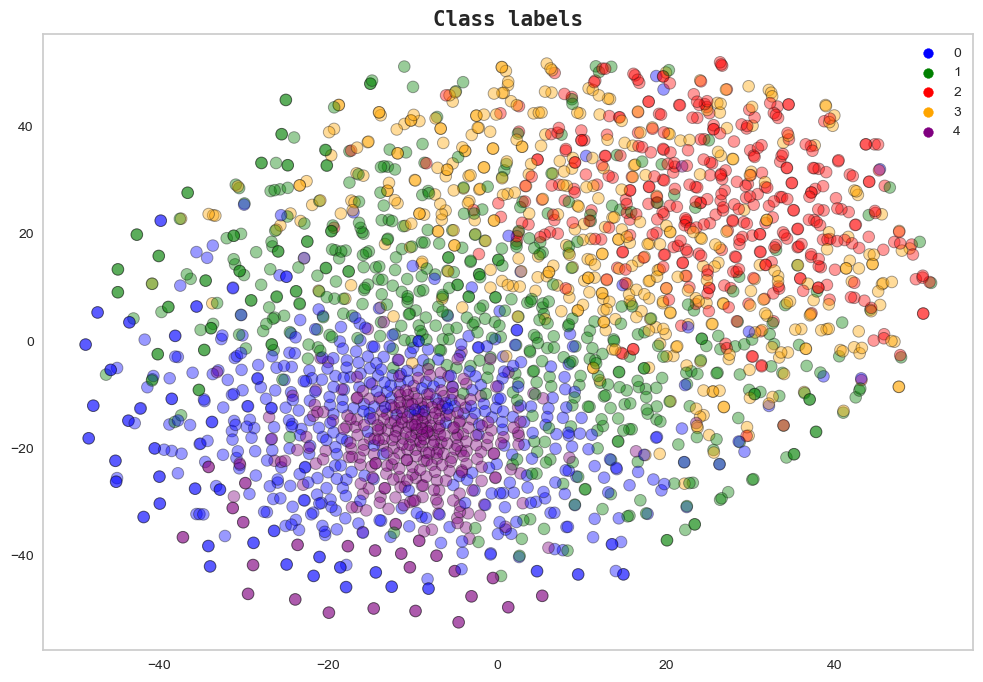

In [25]:
# visualizing class labels

custom_palette = ['blue', 'green', 'red', 'orange', 'purple']

plt.figure(figsize=(12,8))
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=pred, palette=custom_palette, s=70, alpha=.4, ec='k')
plt.grid(None)
plt.title("Class labels", weight='bold', fontfamily='monospace', fontsize=15)
plt.show()

The plot above only confirms what our Silhouette plot showed us.

We will use a Universal encoder in the next section as our embedding and see how well our clustering algorithm performs.

## Part 2: Universal Encoder

In this section, we will use a Universal encoder from tensorflow hub that has been trained on a variety of text data to encode our text data, and see how well our Kmeans model performs.

In [26]:
# loading the Universal encoder

url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(url)

In [27]:
# creating a helper function to encode text data

def embed(input):
    return model(input)

In [28]:
# embedding our data list

df_embeddings = embed(df_list)

In [29]:
# normalizing and reducing the dimensionality of our data

norm_data_tf = norm.fit_transform(df_embeddings)
df_scaled_tf = pca.fit_transform(norm_data_tf)

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

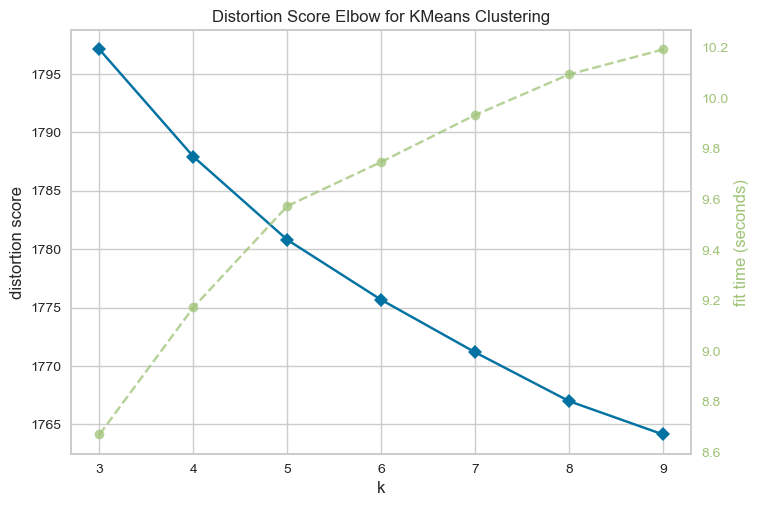

In [30]:
# clustering and visualizing our data

cluster_data(df_scaled_tf, k_min=3, k_max=10)

The plot above is identical to the plot we had when using our Text vectorization layer. Same distortion score. Hence another reason why distortion(inertia) score can be misleading.

Let's see how well our model performs on the Silhouette score metric using the new data and k=5.

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


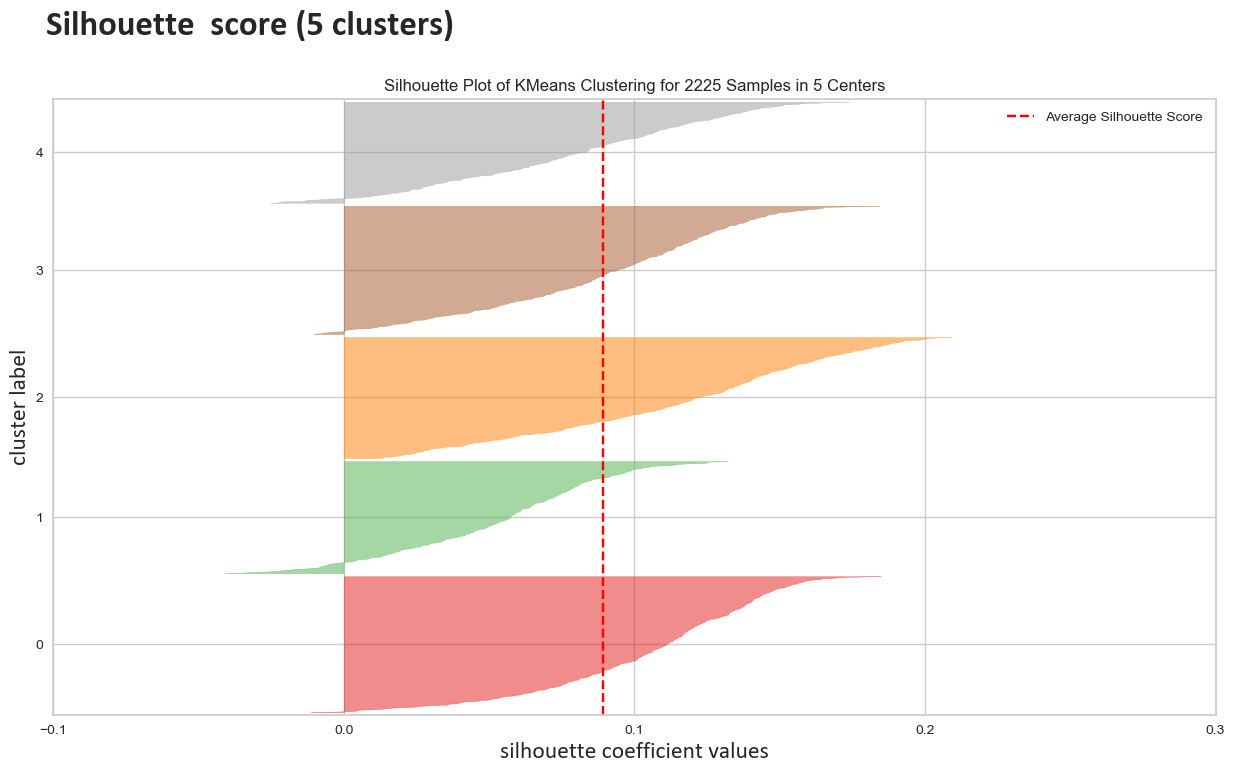

In [31]:
# plotting our Silhoette score

plot_silhouette_score(df_scaled_tf, k=5)

We can see that our model performs better when we use an embedding layer rather than using a TfidVectorizer or Text vectorization layer. The plot above shows that our cluster were evenly are well separated.

Now let's generate our cluster labels and visualize them using a TSNE data

In [32]:
# clustering our data

kmeans = KMeans(n_clusters=5, n_init=100)
pred_tf = kmeans.fit_predict(df_scaled_tf)

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [33]:
# using tsne to further reduce dimensionality

tsne = TSNE()
tsne_data_tf = tsne.fit_transform(df_scaled_tf)

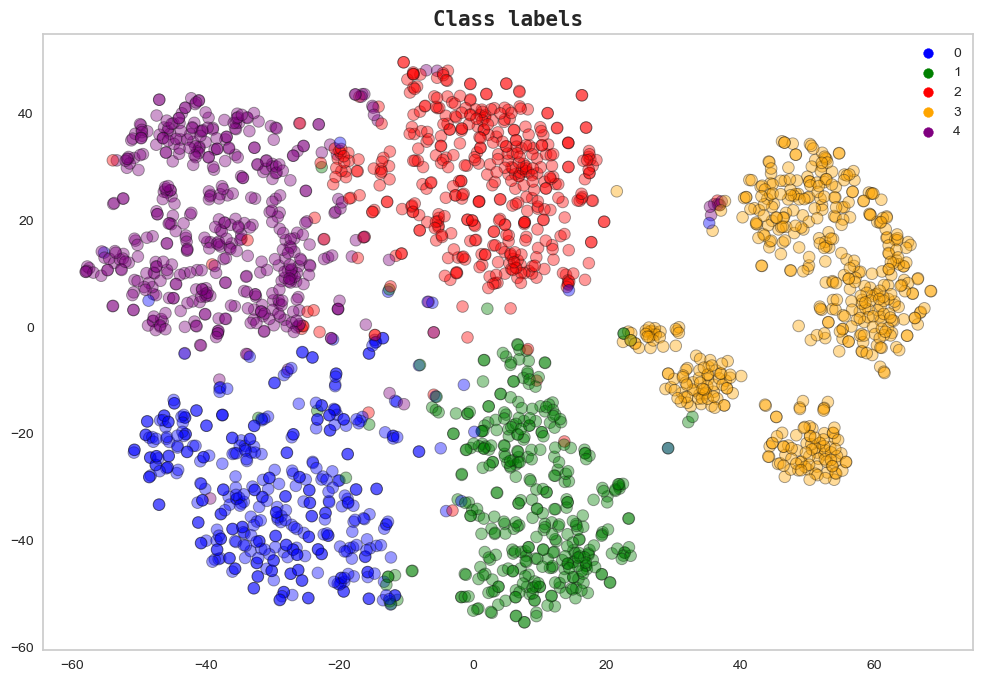

In [34]:
# visualizing class labels

custom_palette = ['blue', 'green', 'red', 'orange', 'purple']

plt.figure(figsize=(12,8))
sns.scatterplot(x=tsne_data_tf[:,0], y=tsne_data_tf[:,1], hue=pred_tf, palette=custom_palette, s=70, alpha=.4, ec='k')
plt.grid(None)
plt.title("Class labels", weight='bold', fontfamily='monospace', fontsize=15)
plt.show()

Now we have a much better result, which was achieved by using a pre-trained embedding. Our cluster labels are well separated compared to the previous model we created (though we still have some overlapping instances)

There are several embedding layers in tensorflow hub that can be used for a variety of tasks.

## Comparing cluster labels to actual labels

We have managed to create a clustering model with satisfactory accuracy, so let's verify our class labels with the actual labels.

This part is tricky considering that this is meant to be an unsupervised learning task with no labels, but we will figure out how to verify them.

In [35]:
# viewing our cluster labels

pred_tf[:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [36]:
# first we will get all the indexes of each cluster from our cluster labels

idx_0 = pred_tf == 0
idx_1 = pred_tf == 1
idx_2 = pred_tf == 2
idx_3 = pred_tf == 3
idx_4 = pred_tf == 4

In [37]:
# next, we will filter our original dataset by these indexes

df_0 = data[idx_0]
df_1 = data[idx_1]
df_2 = data[idx_2]
df_3 = data[idx_3]
df_4 = data[idx_4]

Now we have filtered our data by those indexes, we will find out which category has the highest value count in each filtered datset, and that will be our class name for our cluster label, since from the TSNE plot, we saw that we had a good separation

In [38]:
# df0
print(f"cluster label 0: {df_0['category'].value_counts()[:1].index[0]}")

# df1
print(f"cluster label 1: {df_1['category'].value_counts()[:1].index[0]}")

# df2
print(f"cluster label 2: {df_2['category'].value_counts()[:1].index[0]}")

# df3
print(f"cluster label 3: {df_3['category'].value_counts()[:1].index[0]}")

# df4
print(f"cluster label 4: {df_4['category'].value_counts()[:1].index[0]}")

cluster label 0: tech
cluster label 1: entertainment
cluster label 2: politics
cluster label 3: sport
cluster label 4: business


Now we have our cluster names for our cluster labels, the next step is to map the category in our original dataset to the cluster labels

In [42]:
# mapping category to cluster labels

cluster_map = {
    "tech": 0,
    "entertainment": 1,
    "politics": 2,
    "sport": 3,
    "business": 4
}

data['cluster_labels'] = data['category'].map(cluster_map)

In [43]:
data.head()

,category,filename,title,content,cluster_labels
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,4
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,4
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,4
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,4
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,4


Now we have successfuly mapped our cluster labels to the appropriate indexes, we will now check how well our model performed.

In [44]:
accuracy = (data['cluster_labels'] == pred_tf).sum() / len(data)
print(f"Kmean Model Accuracy: {accuracy:.2%}")

Kmean Model Accuracy: 95.78%


### Conclusion

We were able to create an unsupervised learning clustering model with a `~96%` accuracy by using a pre-trained embedding to preprocess our text. I think this is fantastic!